## Importation des bibliothéques

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import cv2
from skimage import io

import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import *
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import tensorflow.keras.backend as K

import random
import glob
from sklearn.preprocessing import StandardScaler, normalize
from IPython.display import display

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from keras.models import Model, Sequential
from keras.layers import Activation, Dense, BatchNormalization, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Input, Reshape
from keras.optimizers import Adam, SGD
import PIL
from PIL import Image
%matplotlib inline

from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from warnings import filterwarnings

filterwarnings('ignore')
plt.rcParams["axes.grid"] = False
np.random.seed(101)

In [3]:
data = pd.read_csv('../input/lgg-mri-segmentation/kaggle_3m/data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Patient                    110 non-null    object 
 1   RNASeqCluster              92 non-null     float64
 2   MethylationCluster         109 non-null    float64
 3   miRNACluster               110 non-null    int64  
 4   CNCluster                  108 non-null    float64
 5   RPPACluster                98 non-null     float64
 6   OncosignCluster            105 non-null    float64
 7   COCCluster                 110 non-null    int64  
 8   histological_type          109 non-null    float64
 9   neoplasm_histologic_grade  109 non-null    float64
 10  tumor_tissue_site          109 non-null    float64
 11  laterality                 109 non-null    float64
 12  tumor_location             109 non-null    float64
 13  gender                     109 non-null    float64

In [4]:
data_map = []
for sub_dir_path in glob.glob("/kaggle/input/lgg-mri-segmentation/kaggle_3m/"+"*"):
    #if os.path.isdir(sub_path_dir):
    try:
        dir_name = sub_dir_path.split('/')[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + '/' + filename
            data_map.extend([dir_name, image_path])
    except Exception as e:
        print(e)

[Errno 20] Not a directory: '/kaggle/input/lgg-mri-segmentation/kaggle_3m/README.md'
[Errno 20] Not a directory: '/kaggle/input/lgg-mri-segmentation/kaggle_3m/data.csv'


In [5]:
df = pd.DataFrame({"patient_id" : data_map[::2],
                   "path" : data_map[1::2]})
df.head()

,patient_id,path
0,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
1,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
2,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
4,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...


In [6]:
df_imgs = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]

# File path line length images for later sorting
BASE_LEN = 89 # len(/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_ <-!!!43.tif)
END_IMG_LEN = 4 # len(/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->.tif)
END_MASK_LEN = 9 # (/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->_mask.tif)

# Data sorting
imgs = sorted(df_imgs["path"].values, key=lambda x : int(x[BASE_LEN:-END_IMG_LEN]))
masks = sorted(df_masks["path"].values, key=lambda x : int(x[BASE_LEN:-END_MASK_LEN]))

# Sorting check
idx = random.randint(0, len(imgs)-1)
print("Path to the Image:", imgs[idx], "\nPath to the Mask:", masks[idx])

Path to the Image: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_4.tif 
Path to the Mask: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_4_mask.tif


In [7]:
# Final dataframe
brain_df = pd.DataFrame({"patient_id": df_imgs.patient_id.values,
                         "image_path": imgs,
                         "mask_path": masks
                        })
def pos_neg_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 : 
        return 1
    else:
        return 0
    
brain_df['mask'] = brain_df['mask_path'].apply(lambda x: pos_neg_diagnosis(x))
brain_df

,patient_id,image_path,mask_path,mask
0,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
1,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
2,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
4,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
...,...,...,...,...
3924,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3925,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3926,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3927,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0


In [8]:
brain_df_train = brain_df.drop(columns=['patient_id','mask'])

## Le pré-traitement des données

In [9]:
from sklearn.model_selection import train_test_split
train, validt = train_test_split(brain_df_train, test_size=0.15)
test, val = train_test_split(validt, test_size=0.5)
print("Train size is {}, valid size is {} & test size is {}".format(len(train), len(val), len(test)))

train_ids = list(train.image_path)
train_mask = list(train.mask_path)

val_ids = list(val.image_path)
val_mask= list(val.mask_path)

Train size is 3339, valid size is 295 & test size is 295


In [10]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, ids , mask, image_dir = './', batch_size = 16, img_h = 256, img_w = 256, shuffle = True):
        self.ids = ids
        self.mask = mask
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.img_h = img_h
        self.img_w = img_w
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Get the number of batches per epoch'

        return int(np.floor(len(self.ids)) / self.batch_size)

    def __getitem__(self, index):
        'Generate a batch of data'

    #generate index of batch_size length
        indexes = self.indexes[index* self.batch_size : (index+1) * self.batch_size]

    #get the ImageId corresponding to the indexes created above based on batch size
        list_ids = [self.ids[i] for i in indexes]

    #get the MaskId corresponding to the indexes created above based on batch size
        list_mask = [self.mask[i] for i in indexes]


    #generate data for the X(features) and y(label)
        X, y = self.__data_generation(list_ids, list_mask)

    #returning the data
        return X, y

    def on_epoch_end(self):
        'Used for updating the indices after each epoch, once at the beginning as well as at the end of each epoch'
    
    #getting the array of indices based on the input dataframe
        self.indexes = np.arange(len(self.ids))

    #if shuffle is true, shuffle the indices
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_ids, list_mask):
        'generate the data corresponding the indexes in a given batch of images'

    # create empty arrays of shape (batch_size,height,width,depth) 
    #Depth is 3 for input and depth is taken as 1 for output becasue mask consist only of 1 channel.
        X = np.empty((self.batch_size, self.img_h, self.img_w, 3))
        y = np.empty((self.batch_size, self.img_h, self.img_w, 1))

    #iterate through the dataframe rows, whose size is equal to the batch_size
        for i in range(len(list_ids)):
            #path of the image
            img_path = str(list_ids[i])
      
      #mask path
            mask_path = str(list_mask[i])
      
      #reading the original image and the corresponding mask image
            img = io.imread(img_path)
            mask = io.imread(mask_path)

      #resizing and coverting them to array of type float64
            img = cv2.resize(img,(self.img_h,self.img_w))
            img = np.array(img, dtype = np.float64)
      
            mask = cv2.resize(mask,(self.img_h,self.img_w))
            mask = np.array(mask, dtype = np.float64)

      #standardising 
            img -= img.mean()
            img /= img.std()
            if np.sum(mask) > 0:
                mask -= mask.mean()
                mask /= mask.std()
           
      
      #Adding image to the empty array
            X[i,] = img
      
      #expanding the dimnesion of the image from (256,256) to (256,256,1)
            y[i,] = np.expand_dims(mask, axis = 2)
    
    #normalizing y
        y = (y > 0).astype(int)

        return X, y

train_data = DataGenerator(train_ids, train_mask)
val_data = DataGenerator(val_ids, val_mask)

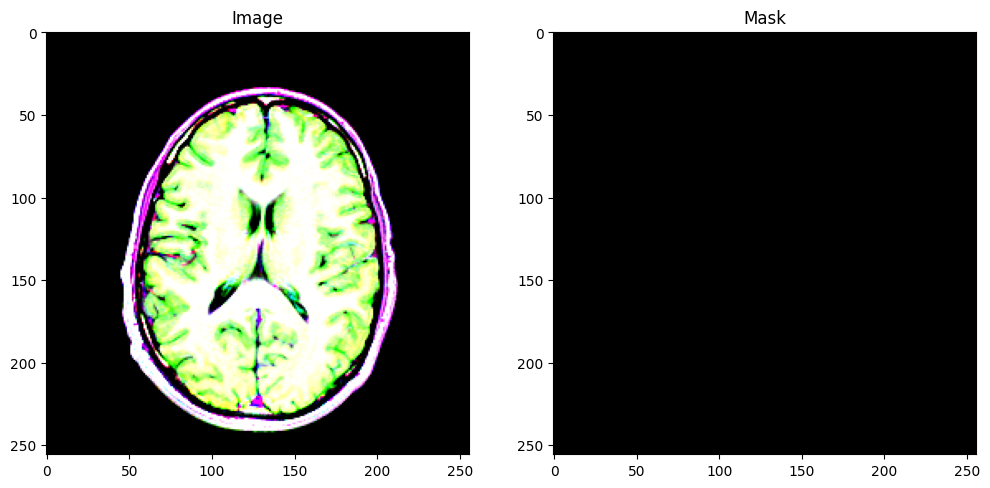

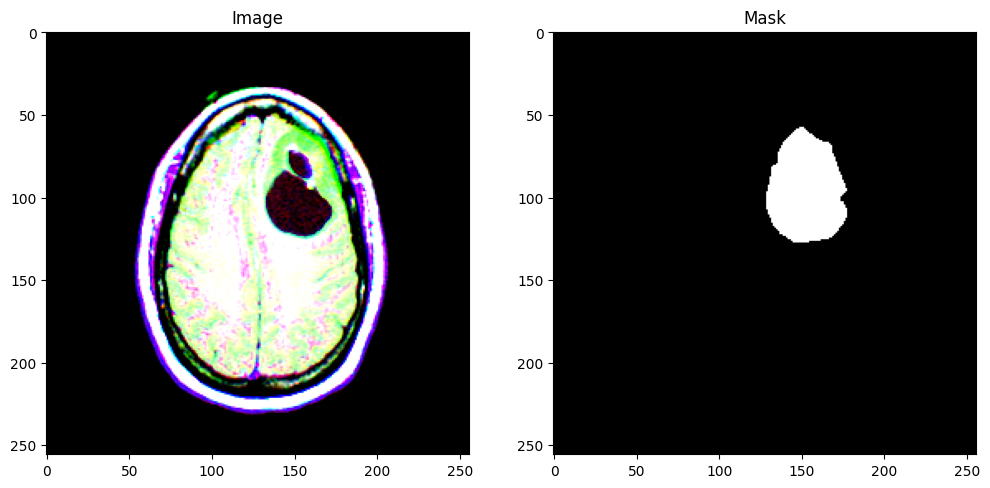

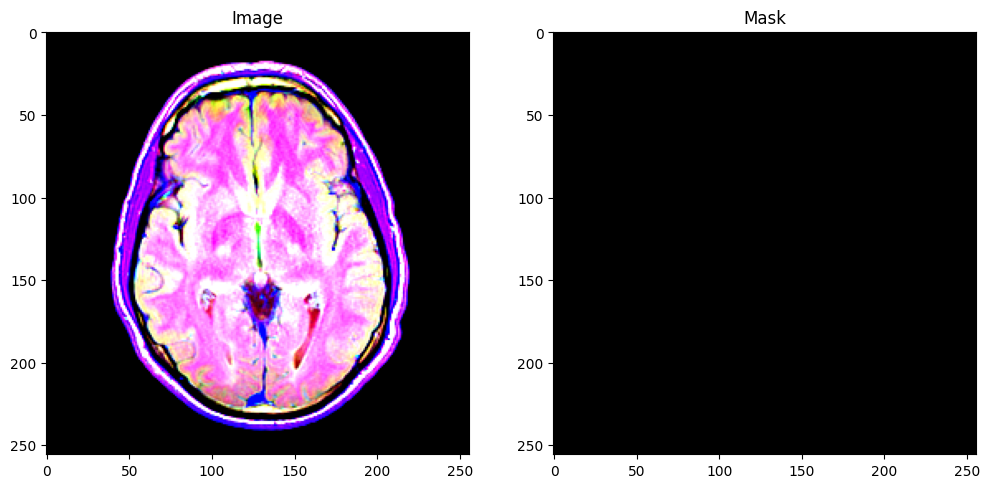

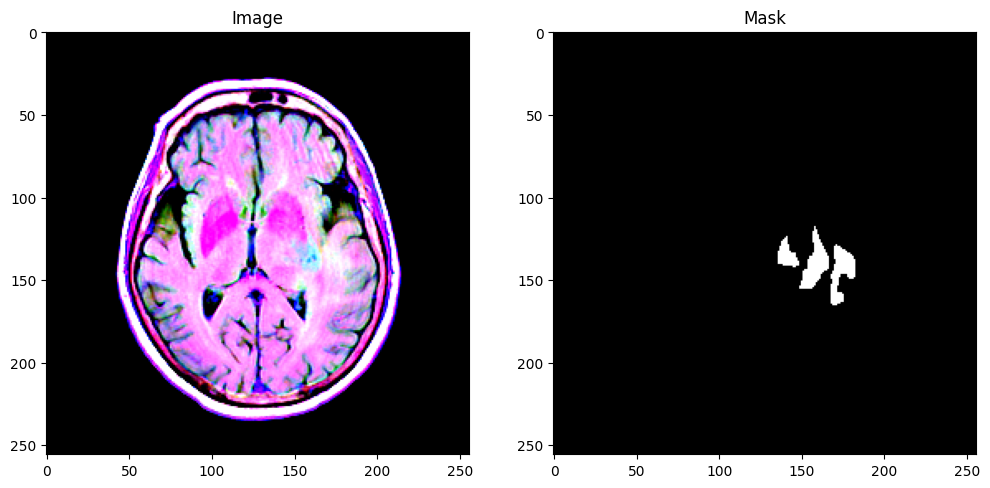

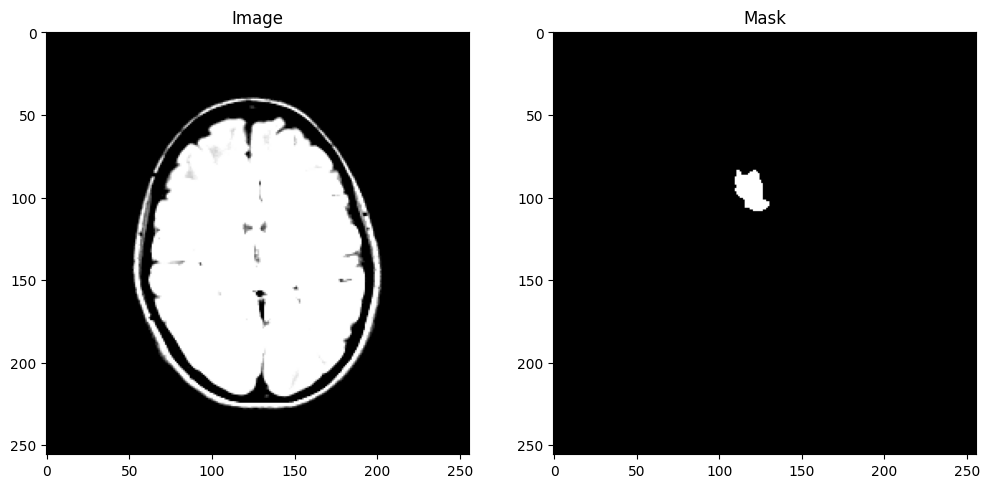

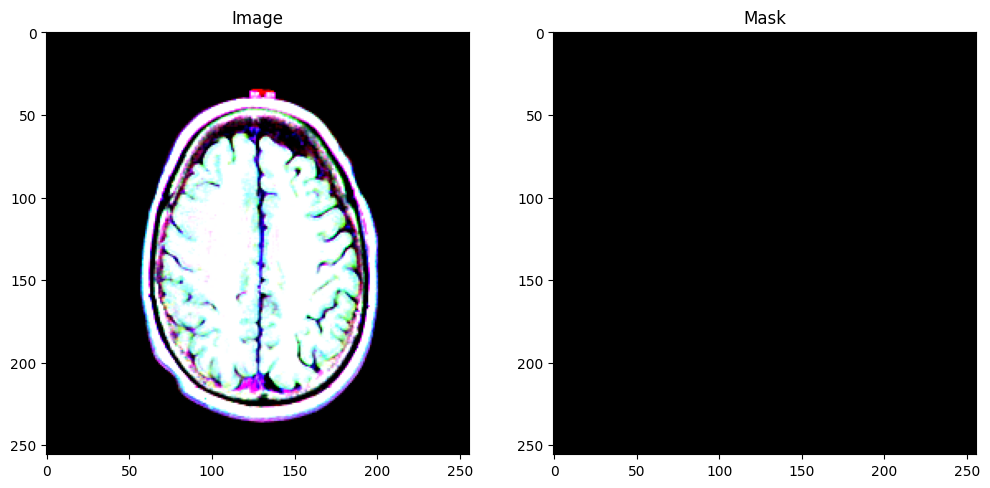

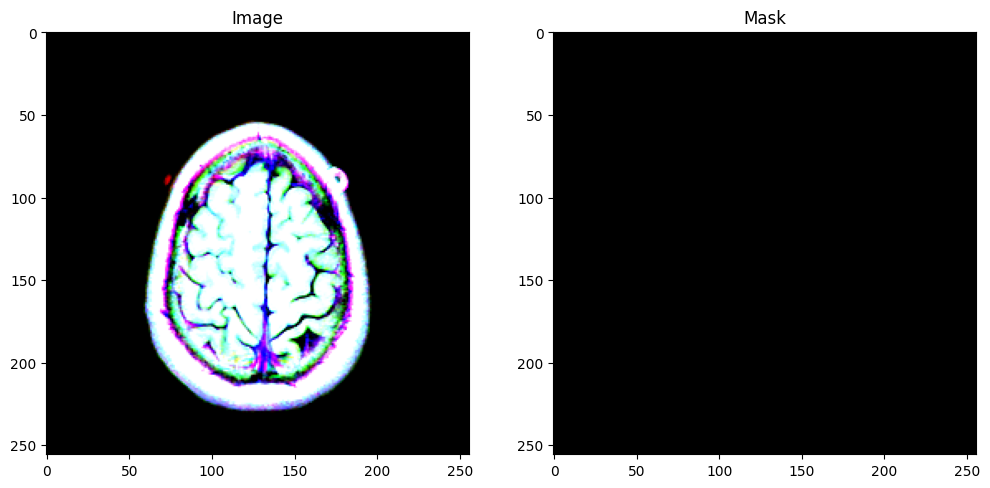

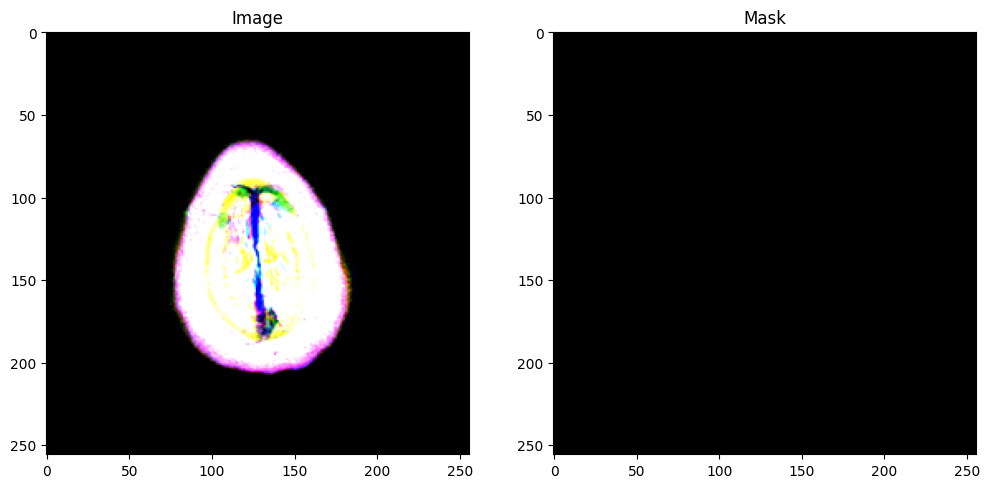

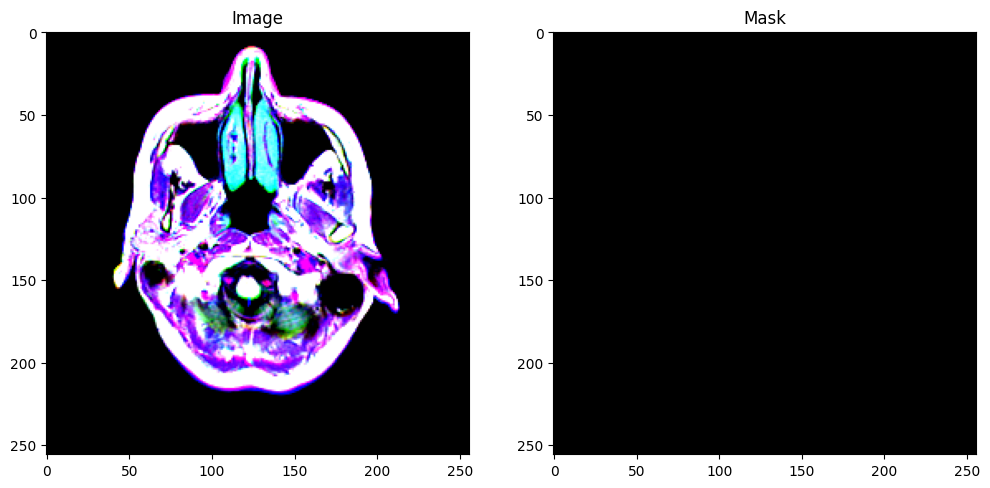

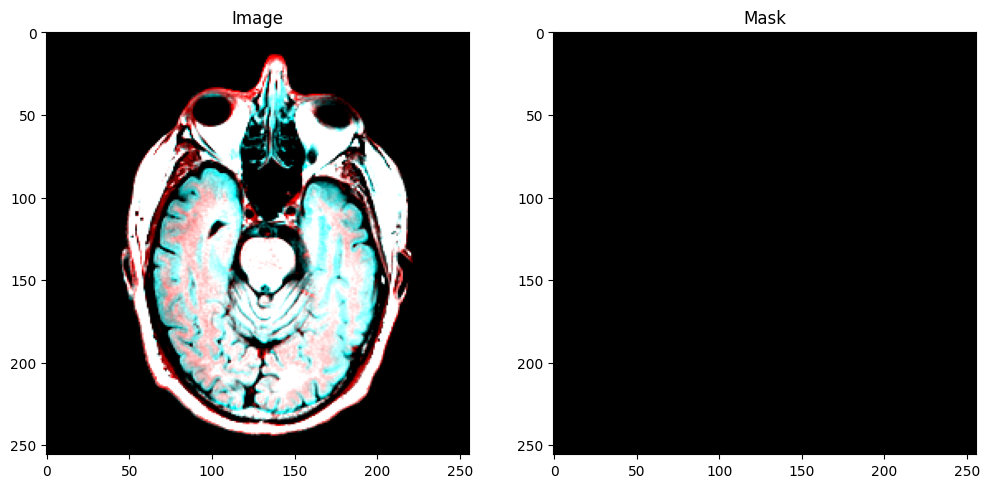

In [11]:
import matplotlib.pyplot as plt

# Définir une fonction pour afficher les images à partir d'un batch
def show_images(generator, num_images=10):
    # Obtenir un batch de données à partir du générateur
    X, y = generator[0]

    # Afficher les images et les masques correspondants
    for i in range(num_images):
        plt.figure(figsize=(12, 6))

        # Afficher l'image
        plt.subplot(1, 2, 1)
        plt.imshow(X[i])
        plt.title('Image')

        # Afficher le masque
        plt.subplot(1, 2, 2)
        plt.imshow(y[i, :, :, 0], cmap='gray')
        plt.title('Mask')

        plt.show()

# Afficher les images du générateur d'entraînement
show_images(train_data)


In [12]:
from PIL import Image

## Les métrics de performance

In [13]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = tf.reduce_sum(tf.cast(y_true, tf.float32) * tf.cast(y_pred, tf.float32))
        union = tf.reduce_sum(tf.cast(y_true, tf.float32)) + tf.reduce_sum(tf.cast(y_pred, tf.float32)) - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)


In [14]:
test_ids = list(test.image_path)
test_mask= list(test.mask_path)
X_test = [Image.open(chemin) for chemin in test_ids]
Y_test=[Image.open(chemin) for chemin in test_mask]
X_val = [Image.open(chemin) for chemin in val_ids]
Y_val=[Image.open(chemin) for chemin in val_mask]

Let us have a look at our transformations.

Now we join all the augmentations image arrays to the original training arrays.

## Le modèle SegNet

In [15]:
def segnet(epochs_num,savename):

    # Encoding layer
    img_input = Input(shape= (256, 256, 3))
    x = Conv2D(64, (3, 3), padding='same', name='conv1',strides= (1,1))(img_input)
    x = BatchNormalization(name='bn1')(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same', name='conv2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(128, (3, 3), padding='same', name='conv3')(x)
    x = BatchNormalization(name='bn3')(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same', name='conv4')(x)
    x = BatchNormalization(name='bn4')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(256, (3, 3), padding='same', name='conv5')(x)
    x = BatchNormalization(name='bn5')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='conv6')(x)
    x = BatchNormalization(name='bn6')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='conv7')(x)
    x = BatchNormalization(name='bn7')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(512, (3, 3), padding='same', name='conv8')(x)
    x = BatchNormalization(name='bn8')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv9')(x)
    x = BatchNormalization(name='bn9')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv10')(x)
    x = BatchNormalization(name='bn10')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(512, (3, 3), padding='same', name='conv11')(x)
    x = BatchNormalization(name='bn11')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv12')(x)
    x = BatchNormalization(name='bn12')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv13')(x)
    x = BatchNormalization(name='bn13')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Dense(1024, activation = 'relu', name='fc1')(x)
    x = Dense(1024, activation = 'relu', name='fc2')(x)
    # Decoding Layer 
    x = UpSampling2D()(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv1')(x)
    x = BatchNormalization(name='bn14')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv2')(x)
    x = BatchNormalization(name='bn15')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv3')(x)
    x = BatchNormalization(name='bn16')(x)
    x = Activation('relu')(x)
    
    x = UpSampling2D()(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv4')(x)
    x = BatchNormalization(name='bn17')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv5')(x)
    x = BatchNormalization(name='bn18')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv6')(x)
    x = BatchNormalization(name='bn19')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv7')(x)
    x = BatchNormalization(name='bn20')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv8')(x)
    x = BatchNormalization(name='bn21')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv9')(x)
    x = BatchNormalization(name='bn22')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv10')(x)
    x = BatchNormalization(name='bn23')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv11')(x)
    x = BatchNormalization(name='bn24')(x)
    x = Activation('relu')(x)
    
    x = UpSampling2D()(x)
    x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv12')(x)
    x = BatchNormalization(name='bn25')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(1, (3, 3), padding='same', name='deconv13')(x)
    x = BatchNormalization(name='bn26')(x)
    x = Activation('sigmoid')(x)
    pred = Reshape((256,256))(x)
    
    model = Model(inputs=img_input, outputs=pred)
    
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=False),
              loss=dice_loss, metrics=[iou, dice_coef, Precision(), Recall()])
    model.summary()
    hist = model.fit(train_data, epochs= epochs_num, batch_size= 20, validation_data= val_data, verbose=1)
    
    model.save(savename)
    return model,hist

## L'entrainement du modéle

In [16]:
from tensorflow.keras.metrics import Recall, Precision

In [17]:
model, hist = segnet(100, 'segnet_brain_tumor_final.h5')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 256, 256, 64)      1792      
                                                                 
 bn1 (BatchNormalization)    (None, 256, 256, 64)      256       
                                                                 
 activation (Activation)     (None, 256, 256, 64)      0         
                                                                 
 conv2 (Conv2D)              (None, 256, 256, 64)      36928     
                                                                 
 bn2 (BatchNormalization)    (None, 256, 256, 64)      256       
                                                                 
 activation_1 (Activation)   (None, 256, 256, 64)      0     

### Plotting Training Statistics

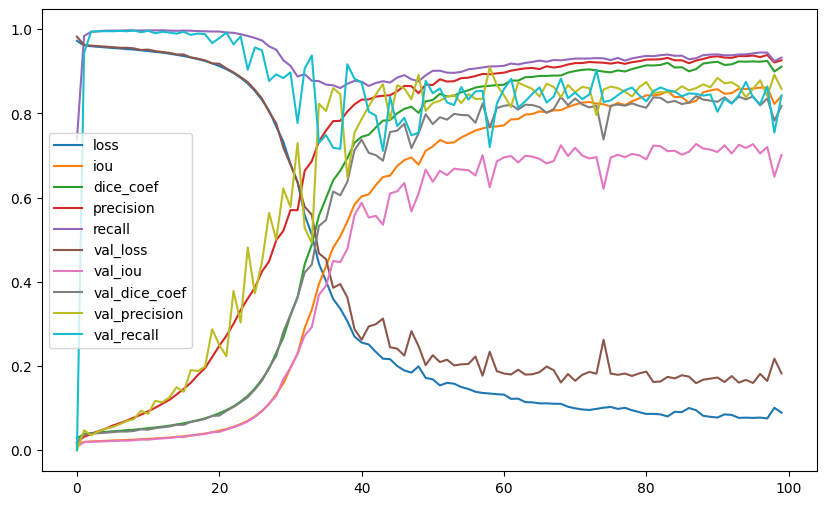

In [18]:
plt.figure(figsize=[10,6])
for key in hist.history.keys():
    plt.plot(hist.history[key], label=key)
    
plt.legend()
plt.show()

## L'évaluation du modèle

In [ ]:
test_ids = list(test.image_path)
test_mask= list(test.mask_path)
test_data = DataGenerator(test_ids, test_mask)
tv = model.evaluate(test_data)
print("Segmentation iou is {:.2f}%".format(tv[1]*100))
print("Segmentation dice_coef is {:.2f}%".format(tv[2]*100))
print("Segmentation precision is {:.2f}%".format(tv[3]*100))
print("Segmentation recall is {:.2f}%".format(tv[4]*100))

In [ ]:
test

In [ ]:
def enhance(img):
    #resized_img = cv2.resize(img, (256, 256))
    #sub = (model.predict(resized_img.reshape(1,256,256,3))).flatten()
    # Resize et normalisation de l'image
    resized_img = cv2.resize(img, (256, 256))
    resized_img = np.array(resized_img, dtype=np.float64)
    resized_img -= resized_img.mean()
    resized_img /= resized_img.std()
     # Prédiction du modèle
    sub = model.predict(resized_img.reshape(1, 256, 256, 3)).flatten()

    for i in range(len(sub)):
        if sub[i] > 0.5:
            sub[i] = 1
        else:
            sub[i] = 0
    return sub



In [ ]:
 imgs,masks=[],[]
# Charger les images et les masques
for i, j in zip(test.image_path, test.mask_path):
    img = io.imread(i)
    mask = io.imread(j)

    # Ajouter les images et les masques aux listes respectives
    imgs.append(img)
    masks.append(mask)
    
imgs = np.array(imgs)
masks = np.array(masks)
  



In [ ]:
# Afficher les images
plt.figure(figsize=(12, 12))
plt.suptitle('Comparing the Prediction after enhancement')
plt.subplot(3,2,1)
plt.imshow(masks[21],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(3,2,2)
plt.imshow(enhance(imgs[21]).reshape(256,256), plt.cm.binary_r)
plt.title('Predicted')
plt.subplot(3,2,3)
plt.imshow(masks[8],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(3,2,4)
plt.imshow(enhance(imgs[8]).reshape(256,256), plt.cm.binary_r)
plt.title('Predicted')
plt.subplot(3,2,5)
plt.imshow(masks[40],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(3,2,6)
plt.imshow(enhance(imgs[40]).reshape(256,256), plt.cm.binary_r)
plt.title('Predicted')
plt.show()


In [ ]:
count = 0
fig, axs = plt.subplots(15,5, figsize=(30,70))

for i in range(100,115):
    if count<15:
        #read mri images
        img = io.imread(test.image_path.iloc[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axs[count][0].imshow(img)
        axs[count][0].title.set_text('Brain MRI')
        #read original mask
        mask_img = io.imread(test.mask_path.iloc[i])
        axs[count][1].imshow(mask_img)
        axs[count][1].title.set_text('Original Mask')

            #read predicted mask
        pred = np.array(enhance(img)).reshape(256, 256).round()
        axs[count][2].imshow(pred)
        axs[count][2].title.set_text('AI predicted mask')

            #overlay original mask with MRI
        img[mask_img==255] = (255,0,0)
        axs[count][3].imshow(img)
        axs[count][3].title.set_text('Brain MRI with original mask (Ground Truth)')
        #overlay predicted mask and MRI
        img_ = io.imread(test.image_path.iloc[i])
        img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
        img_[pred==1] = (0,255,150)
        axs[count][4].imshow(img_)
        axs[count][4].title.set_text('MRI with AI PREDICTED MASK')
        count +=1
    else:
        break
fig.tight_layout()   


In [ ]:
model.save('/kaggle/working/Model_brain_tumor_SegNet_final.hdf5')